# Run `feature_extraction.py` first!

## Imports

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

In [19]:
full_data = pd.read_csv("data/full_features.csv")
submission = pd.read_csv("data/submission_features.csv")
full_data.shape, submission.shape

((1485335, 21), (212192, 21))

In [20]:
full_data.head(1)

,Id,ProductId,UserId,Summary,Text,Score,Month,Year,Helpful,Unhelpful,...,QuestionCount,AllCapsCount,Words,WordCount,TextCleaned,UniqueWords,LemmatizedSummary,LemmatizedCleanedText,SummarySentiment,CleanedTextSentiment
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,good fun film,While most straight to DVD films are not worth...,5.0,6,2012,2,0,...,0,2,While most straight to DVD films are not worth...,155,straight dvd worth watching exception kim basi...,0.748387,good fun film,straight dvd worth watching exception kim basi...,0.7351,-0.5859


## Split

In [30]:
X = full_data.drop(columns=['Id', 'Words'], axis=1)
y = full_data['Score']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Testing Set: {X_test.shape}, {y_test.shape}")

Training Set: (1188268, 19), (1188268,)
Testing Set: (297067, 19), (297067,)


## Getting Train Averages

In [32]:
# Get averages for products and users from train data set
from collections import Counter
product_counts = Counter(X_train['ProductId'])
user_counts = Counter(X_train['UserId'])

product_avg_score = {}
user_avg_score = {}

# first get total scores first
for i, row in X_train.iterrows():
    if (row['ProductId'] not in product_avg_score):
        product_avg_score[row['ProductId']] = row['Score']
        continue
    
    if (row['UserId'] not in user_avg_score): 
        user_avg_score[row['UserId']] = row['Score']
        continue

    product_avg_score[row['ProductId']] += row['Score']
    user_avg_score[row['UserId']] += row['Score']

# then get averages by dividing with count
for product in product_avg_score:
    product_avg_score[product] /= product_counts[product]
    
for user in user_avg_score:
    user_avg_score[user] /= user_counts[user]

In [33]:
# overall average score of training set
overall_avg = np.average(X_train['Score']).item()
overall_avg

4.110520522306416

In [34]:
# Add columns
X_train['ProductAvgScore'] = X_train['ProductId'].map(lambda x: product_avg_score.get(x, overall_avg))
X_train['UserAvgScore'] = X_train['UserId'].map(lambda x: user_avg_score.get(x, overall_avg))
X_train.head(1)

,ProductId,UserId,Summary,Text,Score,Month,Year,Helpful,Unhelpful,ExclaimationCount,...,AllCapsCount,WordCount,TextCleaned,UniqueWords,LemmatizedSummary,LemmatizedCleanedText,SummarySentiment,CleanedTextSentiment,ProductAvgScore,UserAvgScore
985584,6305183260,A36AH31X84FIC8,a horror classic,i can't believe parents had a problem with thi...,5.0,12,1999,0,0,0,...,0,97,believe parents problem scary gore nailbiter s...,0.670103,a horror classic,believe parent problem scary gore nailbiter sa...,-0.5719,-0.8781,3.2,3.781513


In [35]:
# Add columns
X_test['ProductAvgScore'] = X_test['ProductId'].map(lambda x: product_avg_score.get(x, overall_avg))
X_test['UserAvgScore'] = X_test['UserId'].map(lambda x: user_avg_score.get(x, overall_avg))
X_test.head(1)

,ProductId,UserId,Summary,Text,Score,Month,Year,Helpful,Unhelpful,ExclaimationCount,...,AllCapsCount,WordCount,TextCleaned,UniqueWords,LemmatizedSummary,LemmatizedCleanedText,SummarySentiment,CleanedTextSentiment,ProductAvgScore,UserAvgScore
1322849,B001VPJYZK,A1XKXV4BSW11TF,for my wife,"Thank you for having this item, I live on Guam...",5.0,8,2010,0,0,1,...,0,35,thank item live guam find item wife checked am...,0.857143,for my wife,thank item live guam find item wife checked am...,0.0,0.7269,3.448276,5.0


In [36]:
# Add columns
submission['ProductAvgScore'] = submission['ProductId'].map(lambda x: product_avg_score.get(x, overall_avg))
submission['UserAvgScore'] = submission['UserId'].map(lambda x: user_avg_score.get(x, overall_avg))
submission.head(1)

,Id,ProductId,UserId,Summary,Text,Score,Month,Year,Helpful,Unhelpful,...,Words,WordCount,TextCleaned,UniqueWords,LemmatizedSummary,LemmatizedCleanedText,SummarySentiment,CleanedTextSentiment,ProductAvgScore,UserAvgScore
0,1323432,B0034G4P30,A120UTHQDQIJGH,okay for a rental,This movie was just alright for me. I think pe...,NaN,1,2014,0,0,...,This movie was just alright for me I think peo...,169,alright people saying ensemble cast misleading...,0.650888,okay for a rental,alright people saying ensemble cast misleading...,0.2263,0.9866,3.478548,2.545455


In [37]:
# Add counter column
X_train['ProductPopularity'] = X_train['ProductId'].map(lambda x: product_counts.get(x))
X_train['UserPopularity'] = X_train['UserId'].map(lambda x: user_counts.get(x))

# If popularity not in train, default to 0
X_test['ProductPopularity'] = X_test['ProductId'].map(lambda x: product_counts.get(x, 0))
X_test['UserPopularity'] = X_test['UserId'].map(lambda x: user_counts.get(x, 0))
submission['ProductPopularity'] = submission['ProductId'].map(lambda x: product_counts.get(x, 0))
submission['UserPopularity'] = submission['UserId'].map(lambda x: user_counts.get(x, 0))

### See some stats (optional)

In [38]:
X_train.groupby('Score')['ProductPopularity'].describe()

,count,mean,std,min,25%,50%,75%,max
Score,,,,,,,,
1.0,72952.0,136.602424,191.042784,1.0,18.0,65.0,175.0,1569.0
2.0,71742.0,133.641061,189.280443,1.0,19.0,64.0,171.0,1569.0
3.0,140863.0,130.517836,191.260543,1.0,18.0,59.0,163.0,1569.0
4.0,268180.0,131.167794,188.554179,1.0,20.0,63.0,166.0,1569.0
5.0,634531.0,139.093661,197.307891,1.0,21.0,65.0,174.0,1569.0


In [39]:
X_train.groupby('Score')['UserPopularity'].describe()

,count,mean,std,min,25%,50%,75%,max
Score,,,,,,,,
1.0,72952.0,70.496998,191.564511,1.0,6.0,12.0,41.0,1668.0
2.0,71742.0,122.435352,272.995170,1.0,7.0,19.0,87.0,1668.0
3.0,140863.0,135.464018,279.093299,1.0,7.0,21.0,113.0,1668.0
4.0,268180.0,120.358151,252.966113,1.0,7.0,18.0,95.0,1668.0
5.0,634531.0,66.507119,184.117430,1.0,6.0,11.0,35.0,1668.0


<Figure size 1000x600 with 0 Axes>

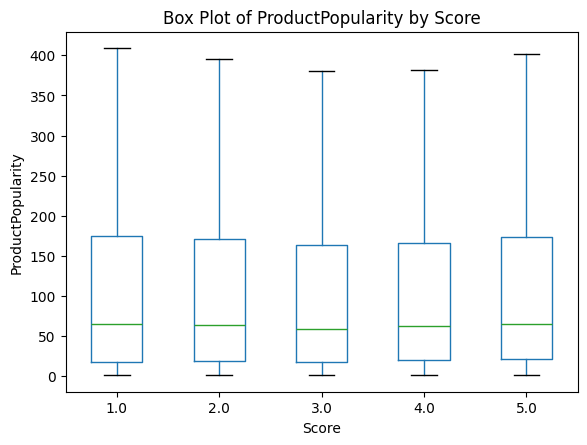

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
X_train.boxplot(column='ProductPopularity', by='Score', grid=False, showfliers=False)
plt.title('Box Plot of ProductPopularity by Score')
plt.suptitle('') 
plt.xlabel('Score')
plt.ylabel('ProductPopularity')
plt.show()

<Figure size 1000x600 with 0 Axes>

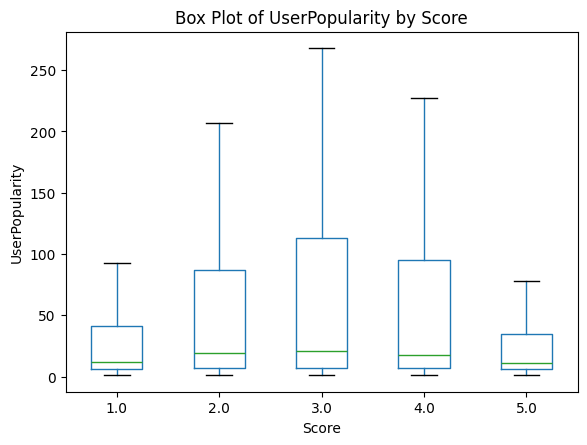

In [41]:
plt.figure(figsize=(10, 6))
X_train.boxplot(column='UserPopularity', by='Score', grid=False, showfliers=False)
plt.title('Box Plot of UserPopularity by Score')
plt.suptitle('') 
plt.xlabel('Score')
plt.ylabel('UserPopularity')
plt.show()

In [44]:
# Add columns to test and submission
# if not there, fallback to training set score average (~4.11)
X_test['ProductAvgScore'] = X_test['ProductId'].map(lambda x: product_avg_score.get(x, overall_avg))
X_test['UserAvgScore'] = X_test['UserId'].map(lambda x: user_avg_score.get(x, overall_avg))
submission['ProductAvgScore'] = submission['ProductId'].map(lambda x: product_avg_score.get(x, overall_avg))
submission['UserAvgScore'] = submission['UserId'].map(lambda x: user_avg_score.get(x, overall_avg))

X_test.head(1)

,ProductId,UserId,Summary,Text,Score,Month,Year,Helpful,Unhelpful,ExclaimationCount,...,TextCleaned,UniqueWords,LemmatizedSummary,LemmatizedCleanedText,SummarySentiment,CleanedTextSentiment,ProductAvgScore,UserAvgScore,ProductPopularity,UserPopularity
1322849,B001VPJYZK,A1XKXV4BSW11TF,for my wife,"Thank you for having this item, I live on Guam...",5.0,8,2010,0,0,1,...,thank item live guam find item wife checked am...,0.857143,for my wife,thank item live guam find item wife checked am...,0.0,0.7269,3.448276,5.0,29,4


## Save files

In [45]:
# X_train = X_train.drop(columns=['ProductId', 'UserId', 'Score'], axis=1)
# X_test = X_test.drop(columns=['ProductId', 'UserId', 'Score'], axis=1)
# submission = submission.drop(columns=['Id', 'Words', 'ProductId', 'UserId', 'Score'], axis=1)

In [46]:
X_train.to_csv("data/components/X_train.csv", index=False, header=True)
X_test.to_csv("data/components/X_test.csv", index=False, header=True)
submission.to_csv("data/components/submission.csv", index=False, header=True)

y_train.to_csv("data/components/y_train.csv", index=False, header=True)
y_test.to_csv("data/components/y_test.csv", index=False, header=True)

In [47]:
## deallocate memory
del X_train
del X_test
del submission
del y_train
del y_test
del full_data